In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import numpy as np
import sys
import os

from nilearn import plotting, masking, datasets, input_data, image, regions
from nistats.thresholding import map_threshold
from nistats.reporting import get_clusters_table

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)

In [3]:
def add_clusters_labels(clusters_table, atlas_img, atlas_label_codes, 
                        atlas_name, inplace=False):
    '''Automatic labeling of activation peaks according to provided brain atlas.
    
    Args:
        clusters_table (DataFrame):
            Output of nistats.reporting.get_clusters_table function. DataFrame
            describing peak activations. If you want to use your custom table 
            make sure that it has three columns: X, Y and Z describing peak
            coordinates in MNI space.
        atlas_img (nibabel.nifti1.Nifti1Image):
            Atlas brain image with values for each voxel corresponding to region
            index.
        atlas_label_codes (dict):
            Mapping between region index and region name. Keys should be 
            integers corresponding to region index and values should be region 
            names.    
        atlas_name (str):
            Name of the brain atlas.
        inplace
            
    Returns:
        Cluster table with additional column corresponding to peak label. 
    '''
    atlas_fdata = atlas_img.get_fdata()

    col_name = f'{atlas_name} label'
    
    if inplace:
        clusters_table_extended = cluster_table
    else:
        clusters_table_extended = clusters_table.copy(deep=True)
    clusters_table_extended[col_name] = ''
    
    for row, cluster in clusters_table.iterrows():

        peak_mni_coords = np.array(cluster.loc[['X', 'Y', 'Z']], dtype='float')
        
        # These peak coordinates correspond to array indices of atlas image
        peak_array_coords = image.coord_transform(
            *peak_mni_coords, 
            np.linalg.inv(atlas_img.affine))
        peak_array_coords = tuple(round(array_coord) 
                                  for array_coord in peak_array_coords)
        
        # Extract region index from atlas image
        region_index = atlas_fdata[peak_array_coords]
        
        # Find corresponding region name
        clusters_table_extended.loc[row, col_name] = atlas_label_codes.get(
            int(region_index), '?') 

    return clusters_table_extended

In [4]:
path_nistats = os.path.join(path_root, 'data/main_fmri_study/derivatives/nistats')
path_second_level_output = os.path.join(path_nistats, 'second_level_output')
path_templates = os.path.join(path_nistats, 'templates')

# Directory to save resulting figures
path_out = os.path.join(path_nistats, 'results')
os.makedirs(path_out, exist_ok=True)

In [5]:
# Load MNI 2009c template
path_mni = os.path.join(
    path_templates, 
    'mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c')
img_mni_09c_t1 = nib.load(
    os.path.join(path_mni, 'mni_icbm152_t1_tal_nlin_asym_09c.nii'))
img_mni_09c_mask = nib.load(
    os.path.join(path_mni, 'mni_icbm152_t1_tal_nlin_asym_09c_mask.nii'))
img_mni_09c_clipped = nib.Nifti1Image(
    img_mni_09c_t1.get_fdata() * img_mni_09c_mask.get_fdata(), 
    img_mni_09c_t1.affine, 
    img_mni_09c_t1.header)

In [6]:
# Load second level SPMs
spm_perr_inc = nib.load(os.path.join(
    path_second_level_output, 
    'statmap-2nd_effect-perr_combined_pos.nii'))
spm_perr_dec = nib.load(os.path.join(
    path_second_level_output, 
    'statmap-2nd_effect-perr_combined_neg.nii'))
spm_perr_rew_minus_pun = nib.load(os.path.join(
    path_second_level_output, 
    'statmap-2nd_effect-perr_rew_minus_pun.nii'))
spm_perr_pun_minus_rew = nib.load(os.path.join(
    path_second_level_output, 
    'statmap-2nd_effect-perr_pun_minus_rew.nii'))

# Load brain parcellations used to label actisvation peaks

### CerebrA atlas

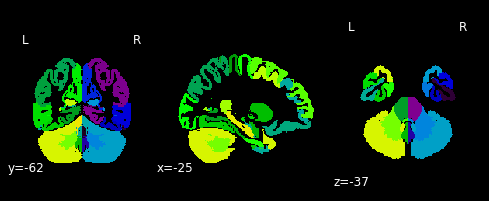

,Mindboggle ID,Label Name,RH Label,LH Label,Notes,Dice Kappa
0,2002,Caudal Anterior Cingulate,30,81,NaN,0.79
1,2003,Caudal Middle Frontal,42,93,Improved distinction from Precentral,0.73
2,2005,Cuneus,43,94,NaN,0.67
3,2006,Entorhinal,36,87,Improved delimitation,0.78
4,2007,Fusiform,24,75,NaN,0.77


In [7]:
# Load CerebrA atlas (MNI 2009c sym space)
path_cerebra = os.path.join(path_templates, 
                            'mni_icbm152_nlin_sym_09c_CerebrA_nifti')
img_mni_09c_cerebra = nib.load(
    os.path.join(path_cerebra, 'mni_icbm152_CerebrA_tal_nlin_sym_09c.nii'))
df_cerebra = pd.read_csv(
    os.path.join(path_cerebra, 'CerebrA_LabelDetails.csv'),
    index_col=False)

# Preprocess CerebrA atlas
df_cerebra_rh = df_cerebra.loc[:, ['Label Name', 'RH Label']]
df_cerebra_lh = df_cerebra.loc[:, ['Label Name', 'LH Label']]
df_cerebra_rh['Label Name'] = df_cerebra_rh['Label Name'] + ' R.'
df_cerebra_lh['Label Name'] = df_cerebra_lh['Label Name'] + ' L.'
df_cerebra_rh.rename(columns={'RH Label': 'Label'}, inplace=True)
df_cerebra_lh.rename(columns={'LH Label': 'Label'}, inplace=True)
df_cerebra_labels = pd.concat([df_cerebra_lh, df_cerebra_rh])

cerebra_label_codes = {
    idx: name 
    for idx, name in 
    zip(df_cerebra_labels['Label'], df_cerebra_labels['Label Name'])}

plotting.plot_anat(img_mni_09c_cerebra, cmap='nipy_spectral', draw_cross=False)
plt.show()

df_cerebra.head()

### AAL atlas

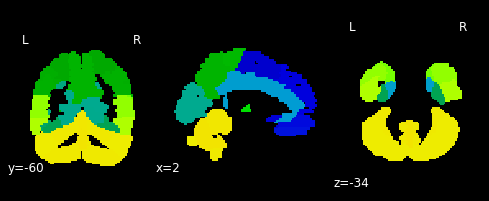

In [8]:
# Load AAL atlas
aal_dataset = datasets.fetch_atlas_aal(
    data_dir=os.path.join(path_templates, 'aal'))

img_aal = nib.load(aal_dataset.maps)
aal_label_codes = {int(idx): name for idx, name in 
                   zip(aal_dataset.indices, aal_dataset.labels)}

plotting.plot_anat(img_aal, cmap='nipy_spectral', draw_cross=False)
plt.show()

### Harvard-Oxford cortical atlas (thr0, 1mm resolution)

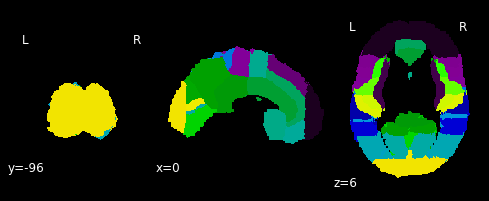

In [157]:
ho_cort_dataset = datasets.fetch_atlas_harvard_oxford(
    atlas_name='cort-maxprob-thr0-1mm',
    data_dir=os.path.join(path_templates, 'harvard_oxford_cortical'))

img_ho_cort = nib.load(ho_cort_dataset.maps)
ho_cort_label_codes = {idx: label 
                       for idx, label in enumerate(ho_cort_dataset.labels)}

plotting.plot_anat(img_ho_cort, cmap='nipy_spectral', draw_cross=False)
plt.show()

### Harvard-Oxford subcortical atlas (thr0, 1mm resolution)

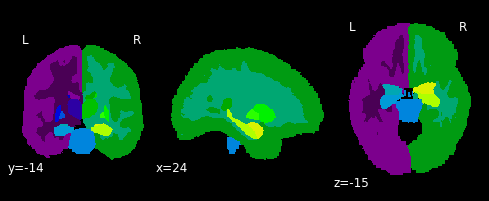

In [160]:
ho_sub_dataset = datasets.fetch_atlas_harvard_oxford(
    atlas_name='sub-maxprob-thr0-1mm',
    data_dir=os.path.join(path_templates, 'harvard_oxford_subcortical'))

img_ho_sub = nib.load(ho_sub_dataset.maps)
ho_sub_label_codes = {idx: label 
                      for idx, label in enumerate(ho_sub_dataset.labels)}

plotting.plot_anat(img_ho_sub, cmap='nipy_spectral', draw_cross=False)
plt.show()

## Combined effect of prediction error encoding

Here we threshold second level statistical paramet maps (spm's) for prediction error effect combined for both task conditions. We use two-sided test with false discovery rate (FDR) correction to detect brain regions:
- with activity scaling positively with increasing prediction error (+PE regions)
- with activity scaling negatively with increasing prediction error (-PE regions)

We used corrected p-value threshold of 0.00001 and cluster forming threshold of 20 connected voxels.

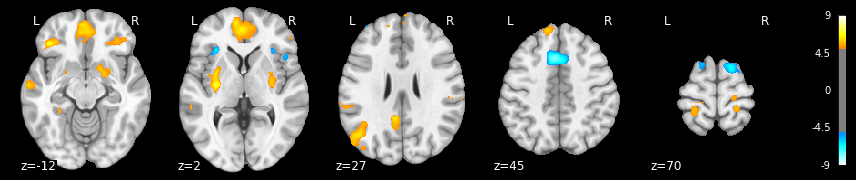

In [182]:
activations_perr_inc, thr_perr_inc = map_threshold(
    spm_perr_inc,
    mask_img=img_mni_09c_mask,
    alpha=0.00001,
    height_control='fdr',
    cluster_threshold=20,
    two_sided=True
)

plotting.plot_img(
    activations_perr_inc, 
    bg_img=img_mni_09c_clipped,
    display_mode='z',
    cut_coords=(-12, 2, 27, 45, 70),
    threshold=thr_perr_inc,
    vmax=9,
    vmin=-9,
    black_bg=True,
    colorbar=True,
    cmap='cold_hot'
)

In [161]:
clusters_inc = get_clusters_table(spm_perr_inc, 
                                  stat_threshold=thr_perr_inc, 
                                  cluster_threshold=20)
clusters_dec = get_clusters_table(spm_perr_dec, 
                                  stat_threshold=thr_perr_inc, 
                                  cluster_threshold=20)

for cluster_table in [clusters_inc, clusters_dec]:
    add_clusters_labels(cluster_table, img_mni_09c_cerebra, cerebra_label_codes, 'CerebrA', inplace=True)
    add_clusters_labels(cluster_table, img_aal, aal_label_codes, 'AAL', inplace=True)    
    add_clusters_labels(cluster_table, img_ho_cort, ho_cort_label_codes, 'HO Cortical', inplace=True)
    add_clusters_labels(cluster_table, img_ho_sub, ho_sub_label_codes, 'HO Subcortical', inplace=True)

In [162]:
clusters_inc

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),CerebrA label,AAL label,HO Cortical label,HO Subcortical label
0,1,-30.0,-12.0,2.5,7.195100,2772,Putamen L.,Putamen_L,Background,Left Putamen
1,1a,-30.0,0.0,6.0,6.635755,,Putamen L.,Putamen_L,Background,Left Putamen
2,1b,-27.0,-3.0,16.5,5.601178,,?,?,Background,Left Cerebral White Matter
3,2,-39.0,33.0,-11.5,6.998819,1071,Pars Orbitalis L.,Frontal_Inf_Orb_L,Frontal Orbital Cortex,Left Cerebral Cortex
4,3,-3.0,48.0,-1.0,6.956164,11970,Superior Frontal L.,Cingulum_Ant_L,Paracingulate Gyrus,Left Cerebral Cortex
5,3a,-6.0,57.0,-4.5,6.914739,,Superior Frontal L.,Frontal_Med_Orb_L,Frontal Pole,Left Cerebral Cortex
6,3b,3.0,60.0,9.5,5.808350,,Superior Frontal R.,Frontal_Sup_Medial_R,Frontal Pole,Right Cerebral Cortex
7,3c,0.0,48.0,-22.0,5.561813,,?,Rectus_L,Frontal Medial Cortex,Right Cerebral Cortex
8,4,30.0,-9.0,6.0,6.499816,1323,Putamen R.,Putamen_R,Background,Right Putamen
9,5,-48.0,-66.0,27.0,6.451357,4567,Inferior Parietal L.,Angular_L,"Lateral Occipital Cortex, superior division",Left Cerebral Cortex


In [163]:
clusters_dec

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),CerebrA label,AAL label,HO Cortical label,HO Subcortical label
0,1,-6.0,18.0,44.5,7.856539,6709,Superior Frontal L.,Supp_Motor_Area_L,Paracingulate Gyrus,Left Cerebral Cortex
1,1a,0.0,12.0,51.5,7.813665,,?,Supp_Motor_Area_L,Paracingulate Gyrus,Left Cerebral Cortex
2,2,15.0,9.0,69.0,6.794687,1165,?,Supp_Motor_Area_R,Superior Frontal Gyrus,Right Cerebral Cortex
3,3,-33.0,24.0,6.0,6.504029,945,?,Insula_L,Frontal Operculum Cortex,Left Cerebral Cortex


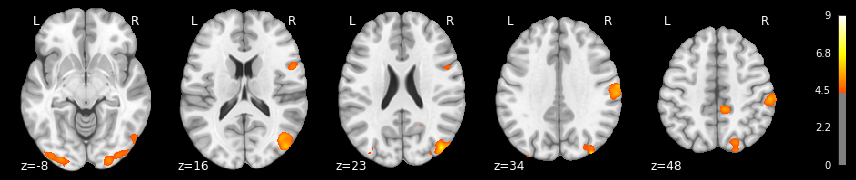

In [184]:
activations_perr_rew_minus_pun, thr_perr_rew_minus_pun = map_threshold(
    spm_perr_rew_minus_pun,
    mask_img=img_mni_09c_mask,
    alpha=0.001,
    height_control='fdr',
    cluster_threshold=20,
    two_sided=True
)

img = plotting.plot_img(
    activations_perr_rew_minus_pun, 
    bg_img=img_mni_09c_clipped,
    display_mode='z',
    cut_coords=(-8, 16, 23, 34, 48),
    threshold=thr_perr_rew_minus_pun,
    black_bg=True,
    colorbar=True,
    vmin=0,
    vmax=9,
    cmap='hot'
)

In [164]:
clusters_perr_rew_minus_pun = get_clusters_table(
    spm_perr_rew_minus_pun, 
    stat_threshold=thr_perr_rew_minus_pun, 
    cluster_threshold=20)

for cluster_table in [clusters_perr_rew_minus_pun]:
    add_clusters_labels(cluster_table, img_mni_09c_cerebra, cerebra_label_codes, 'CerebrA', inplace=True)
    add_clusters_labels(cluster_table, img_aal, aal_label_codes, 'AAL', inplace=True)
    add_clusters_labels(cluster_table, img_ho_cort, ho_cort_label_codes, 'HO Cortical', inplace=True)
    add_clusters_labels(cluster_table, img_ho_sub, ho_sub_label_codes, 'HO Subcortical', inplace=True)
    
clusters_perr_rew_minus_pun

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),CerebrA label,AAL label,HO Cortical label,HO Subcortical label
0,1,42.0,-81.0,23.5,6.525309,12694,Inferior Parietal R.,Occipital_Mid_R,"Lateral Occipital Cortex, superior division",Right Cerebral Cortex
1,1a,36.0,-87.0,34.0,5.984989,,Inferior Parietal R.,Occipital_Mid_R,"Lateral Occipital Cortex, superior division",Right Cerebral Cortex
2,1b,42.0,-69.0,16.5,5.589811,,Lateral Occipital R.,Temporal_Mid_R,"Lateral Occipital Cortex, superior division",Right Cerebral Cortex
3,1c,45.0,-81.0,-1.0,5.379307,,?,Occipital_Mid_R,"Lateral Occipital Cortex, inferior division",Right Cerebral Cortex
4,2,60.0,-18.0,30.5,6.194235,4158,Supramarginal R.,Postcentral_R,Postcentral Gyrus,Right Cerebral Cortex
5,2a,63.0,-24.0,41.0,5.819027,,Supramarginal R.,SupraMarginal_R,"Supramarginal Gyrus, anterior division",Right Cerebral Cortex
6,3,9.0,-39.0,48.0,5.514336,1008,Precuneus R.,Cingulum_Mid_R,Precuneous Cortex,Right Cerebral Cortex
7,4,18.0,-66.0,58.5,5.298635,2898,Superior Parietal R.,Parietal_Sup_R,"Lateral Occipital Cortex, superior division",Right Cerebral Cortex
8,4a,21.0,-75.0,48.0,5.118384,,Superior Parietal R.,Parietal_Sup_R,"Lateral Occipital Cortex, superior division",Right Cerebral Cortex
9,4b,21.0,-84.0,48.0,4.955645,,Superior Parietal R.,Occipital_Sup_R,"Lateral Occipital Cortex, superior division",Right Cerebral Cortex
